In [ ]:
#from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%pip install fast_ml

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from fast_ml.model_development import train_valid_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score


# Introduction

We are training a regression model to predict the **Frequentation** target by using the day and meteorological features

We will have to choose between the following regression model :
- Random Forest
- Multiple Regression
- AdaBoost
- XGBoost

# Data Preparation

We import our two dataset

In [ ]:
df = pd.read_csv("dataset", sep=';')
df.head(1)

,heure,year,month,day,Frequentation,isWeekday,isHoliday,season,RR1,QRR1,...,NEIGETOT,QNEIGETOT,GLO,QGLO,GLO2,QGLO2,INS,QINS,INS2,QINS2
0,00:00,2022,1,1,1469,False,True,winter,0.0,1.0,...,NaN,NaN,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0


In [ ]:
df_mean = pd.read_csv("mean_dataset", sep=';')
df_mean.head(1)

,heure,season,isWeekday,isHoliday,identifiantLigne,Frequentation
0,00:00,autumn,False,False,1001.0,1758.894737


In [ ]:
df.describe()

,year,month,day,Frequentation,RR1,QRR1,DRR1,QDRR1,FF,QFF,...,NEIGETOT,QNEIGETOT,GLO,QGLO,GLO2,QGLO2,INS,QINS,INS2,QINS2
count,18308.000000,18308.000000,18308.000000,18308.000000,17938.000000,18307.0,17873.000000,18242.000000,18304.000000,18304.000000,...,15385.0,15385.0,18307.000000,18307.000000,18300.000000,18300.000000,18306.000000,18306.000000,18301.000000,18301.000000
mean,2022.947782,6.376174,15.727988,4471.575541,0.073955,1.0,4.076540,8.838176,3.680359,1.000874,...,0.0,9.0,54.758398,8.999563,54.701858,8.999563,14.013056,8.998689,14.002022,8.999126
std,0.761793,3.405244,8.787015,4291.963559,0.490167,0.0,12.761476,1.126267,2.002543,0.083622,...,0.0,0.0,80.872149,0.059126,80.830810,0.059138,21.801135,0.102407,21.787113,0.083629
min,2022.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,...,0.0,9.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,2022.000000,3.000000,8.000000,1146.000000,0.000000,1.0,0.000000,9.000000,2.200000,1.000000,...,0.0,9.0,0.000000,9.000000,0.000000,9.000000,0.000000,9.000000,0.000000,9.000000
50%,2023.000000,6.000000,16.000000,3277.500000,0.000000,1.0,0.000000,9.000000,3.400000,1.000000,...,0.0,9.0,6.000000,9.000000,6.000000,9.000000,0.000000,9.000000,0.000000,9.000000
75%,2024.000000,9.000000,23.000000,6610.500000,0.000000,1.0,0.000000,9.000000,4.800000,1.000000,...,0.0,9.0,87.500000,9.000000,88.000000,9.000000,26.000000,9.000000,26.000000,9.000000
max,2024.000000,12.000000,31.000000,21592.000000,22.000000,1.0,60.000000,9.000000,14.700000,9.000000,...,0.0,9.0,351.000000,9.000000,349.000000,9.000000,60.000000,9.000000,60.000000,9.000000


As the model we are using only use numerical features, we have to transform our dataset into one that is ready for the given algorithm

## Features engineering

We check for non numerical datas as the model we are trying to implements only accept numerical input

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18308 entries, 0 to 18307
Columns: 116 entries, heure to QINS2
dtypes: bool(2), float64(108), int64(4), object(2)
memory usage: 16.0+ MB


We have 2 boolean features, and 2 object features

In [ ]:
colonnes_object = df.select_dtypes(include=['object']).columns
print("Colonnes de type 'object' :", colonnes_object)

Colonnes de type 'object' : Index(['heure', 'season'], dtype='object')


We tranform our data to numerical data

First we convert the hour to integer

In [ ]:
df['heure'] = df['heure'].str.slice(start=0, stop=2).astype(int)

df_mean['heure'] = df_mean['heure'].str.slice(start=0, stop=2).astype(int)

We then convert the boolean featutes by replacing True with 1 and False with 0

In [ ]:
df['isWeekday'] = df['isWeekday'].replace({False:0, True:1})
df['isHoliday'] = df['isHoliday'].replace({False:0, True:1})

df_mean['isWeekday'] = df_mean['isWeekday'].replace({False:0, True:1})
df_mean['isHoliday'] = df_mean['isHoliday'].replace({False:0, True:1})

Lastly, we one hot encode the categorical feature *season*

In [ ]:
# we keep the season column for later
df_season = df['season']

In [ ]:
df = pd.get_dummies(df, columns=['season'], drop_first=False)

As some of the algorithm accept missing values, we will adapt the management of missing values for each algorithm

In [ ]:
df_mean = df_mean.drop(columns=['identifiantLigne'])

We have the following dataset

In [ ]:
df

,heure,year,month,day,Frequentation,isWeekday,isHoliday,RR1,QRR1,DRR1,...,GLO2,QGLO2,INS,QINS,INS2,QINS2,season_autumn,season_spring,season_summer,season_winter
0,0,2022,1,1,1469,0,1,0.0,1.0,0.0,...,0.0,9.0,0.0,9.0,0.0,9.0,False,False,False,True
1,1,2022,1,1,910,0,1,0.0,1.0,0.0,...,0.0,9.0,0.0,9.0,0.0,9.0,False,False,False,True
2,2,2022,1,1,535,0,1,0.0,1.0,0.0,...,0.0,9.0,0.0,9.0,0.0,9.0,False,False,False,True
3,3,2022,1,1,200,0,1,0.0,1.0,0.0,...,0.0,9.0,0.0,9.0,0.0,9.0,False,False,False,True
4,4,2022,1,1,406,0,1,0.0,1.0,0.0,...,0.0,9.0,0.0,9.0,0.0,9.0,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18303,19,2024,9,30,6291,1,0,0.0,1.0,0.0,...,0.0,9.0,0.0,9.0,0.0,9.0,True,False,False,False
18304,20,2024,9,30,7431,1,0,0.0,1.0,0.0,...,0.0,9.0,0.0,9.0,0.0,9.0,True,False,False,False
18305,21,2024,9,30,2081,1,0,0.0,1.0,0.0,...,0.0,9.0,0.0,9.0,0.0,9.0,True,False,False,False
18306,22,2024,9,30,2318,1,0,0.0,1.0,0.0,...,0.0,9.0,0.0,9.0,0.0,9.0,True,False,False,False


## Dimension reduction

We try to see if we can use a dimension reduction technique to higher our performance

As we only have numerical features, we use the PCA algorithm

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

We replace the NaN by 0 because the pca algorithm does not support

In [ ]:
cluster_df = df.drop(columns=['Frequentation']).fillna(0)

We start by scaling our data

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(cluster_df)


And we apply the PCA algorithm

In [ ]:
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

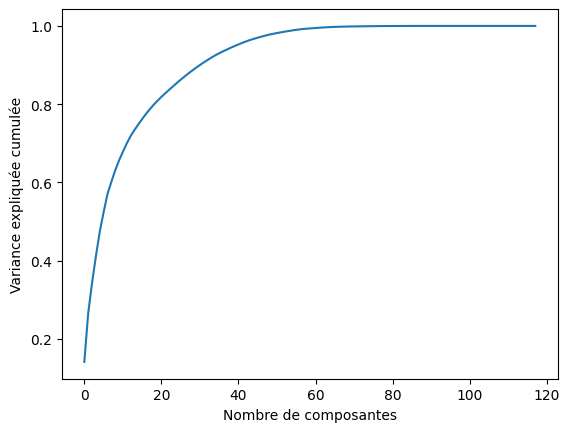

In [ ]:
np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.show()

We see that with the 20 first principal features, we explain 80% of the variance inside our dataset

In [ ]:
df_pca = df_pca[:,:20]
df_pca.shape

(18308, 20)

We think that we have to take too many principal features to explain most of the variance so we will not use PCA alone (as it will lower the interpretability and over complexify our model) but it might be usefull for clustering to find trends in our data that we could use to increase the performance of the model

## Cluster

We also try to highlights the presence of cluster in our data

If we find separated cluster, this could help inprove the performance of our model since we could train different model on different cluster, and lower our bias on the different cluster

In [ ]:
from sklearn.cluster import KMeans

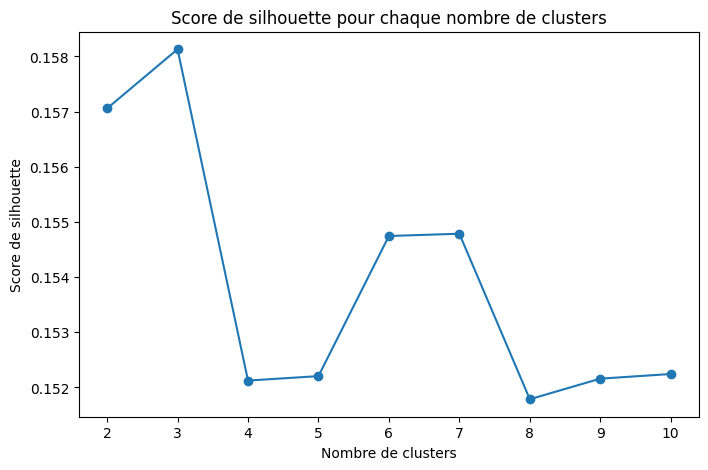

In [ ]:
from sklearn.metrics import silhouette_score
# Calculer le score de silhouette pour différents nombres de clusters
silhouette_scores = []

for k in range(2, 11):  # On ne peut pas calculer de silhouette pour 1 cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(df_pca)
    score = silhouette_score(df_pca, clusters)
    silhouette_scores.append(score)

# Tracer le score de silhouette
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette pour chaque nombre de clusters')
plt.show()

We see that our silhouette scores are really low and this tells us that we have no separated cluster in our data

We see this in the different projections that we have below

### K-Means

We first use the k-means algorithm

In [ ]:
# Appliquer K-Means sur les données réduites
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_pca)
# Ajouter les clusters au DataFrame original
clusters = kmeans.labels_


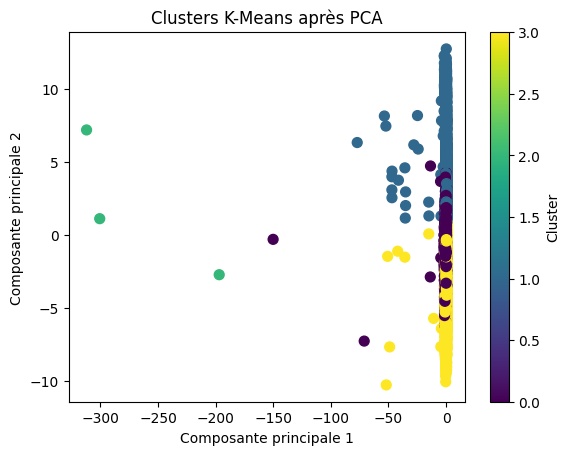

In [ ]:
# Visualiser les clusters dans le plan formé par les deux premières composantes
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis', s=50)
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Clusters K-Means après PCA')
plt.colorbar(label='Cluster')
plt.show()

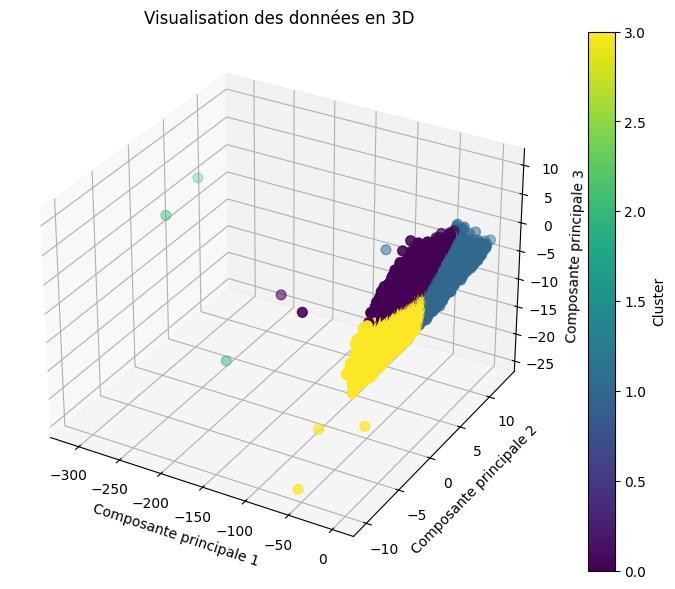

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Supposons que data_pca contient les 3 premières dimensions
data_3d = df_pca[:, :3]  # Prendre les 3 premières dimensions

# Si vous avez des clusters, ajoutez-les pour colorer les points
clusters = kmeans.labels_  # Assurez-vous que vous avez appliqué K-Means

# Création de la figure 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Tracer les points
sc = ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c=clusters, cmap='viridis', s=50)

# Ajouter des étiquettes
ax.set_xlabel('Composante principale 1')
ax.set_ylabel('Composante principale 2')
ax.set_zlabel('Composante principale 3')
plt.title("Visualisation des données en 3D")

# Ajouter une barre de couleurs pour les clusters
plt.colorbar(sc, ax=ax, label='Cluster')

plt.show()


### HAC

We try with the hierchical ascending clustering algorithm

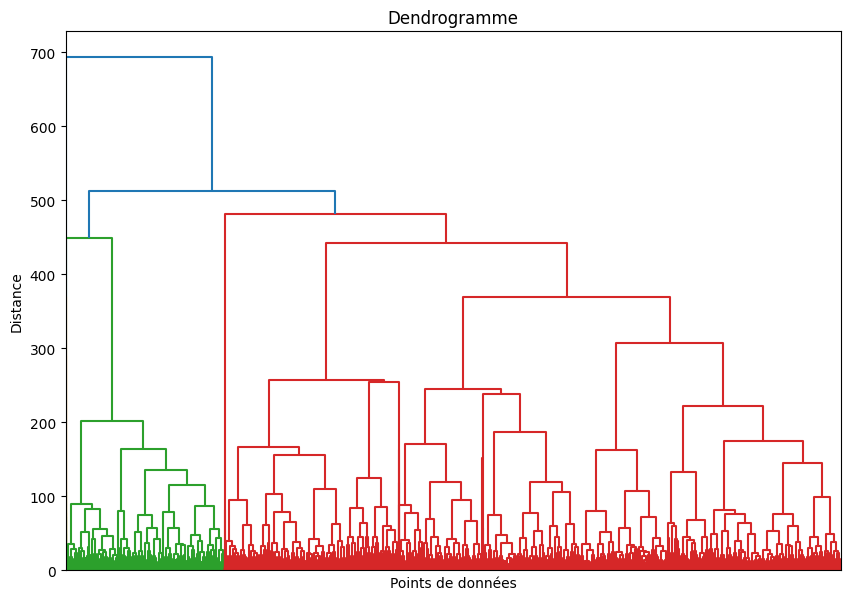

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Générer une matrice de liens (méthode ward pour minimiser la variance intra-cluster)
Z = linkage(df_pca[:,:20], method='ward')

# Dessiner le dendrogramme
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogramme')
plt.xlabel('Points de données')
plt.ylabel('Distance')
plt.xticks([])
plt.show()


### T-SNE

We try to find cluster with the tsne algorithm

In [ ]:
from sklearn.manifold import TSNE

# Réduction des dimensions à 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
data_tsne = tsne.fit_transform(df_scaled)


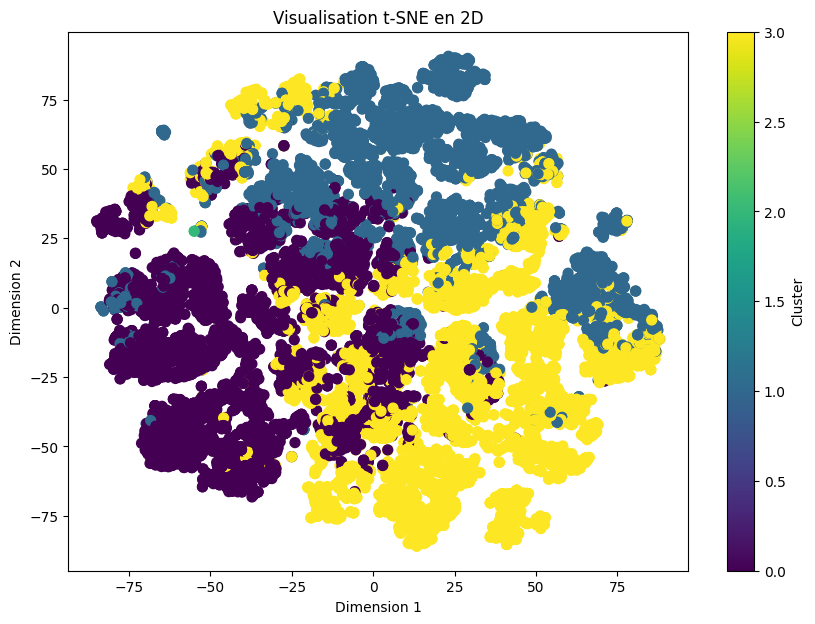

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=clusters, cmap='viridis', s=50)  # clusters = étiquettes si disponibles
plt.colorbar(label='Cluster')
plt.title("Visualisation t-SNE en 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### Conclusion of the cluster approach

We do not find any interesting enough cluster to split our dataset to help the prediction, thus we continue with the whole dataset as one

## Split of the Dataset

We create our different dataset :
- **Training** : Train our final model
- **Validation** : Choose between the different model
- **Test** : Assess the performance of our final model

In [ ]:
df['season'] = df_season

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target='Frequentation', train_size=0.6, valid_size=0.2, test_size=0.2)

In [ ]:
X_test_season = X_test['season']
for d in [X_train, X_valid, X_test]:
    d.drop(columns=['season'], inplace=True)

We can now use the validation dataset to

# Prediction

## Cross validation

We will use the k-fold cross validation method as we have a large amount of data

We will use the following metrics to assess the performance of our model :
- MAE
- RMSE
- R2

We initialize the benchmark storing list

In [ ]:
benchmark = []

In [ ]:
kf = KFold(n_splits=10,random_state=520,shuffle=True)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X_rf = X_valid.copy()
y_rf = y_valid.copy()

In [ ]:
rf = RandomForestRegressor(random_state=520)

In [ ]:
rf_scores = []

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(X_rf)):

    X_rf_train, X_rf_test, y_rf_train, y_rf_test = X_rf.iloc[train_index], X_rf.iloc[test_index], y_rf.iloc[train_index], y_rf.iloc[test_index]

    rf.fit(X_rf_train, y_rf_train)
    preds = rf.predict(X_rf_test)

    mae = mean_absolute_error(y_rf_test, preds)
    rmse = root_mean_squared_error(y_rf_test, preds)
    r2 = r2_score(y_rf_test, preds)

    print(f'iter {i} : {mae}')

    rf_scores.append([mae, rmse, r2])

print('----- score moyen -----')
rf_score = np.mean(rf_scores, axis=0)
print('Random Forest :')
print(rf_score)

iter 0 : 834.4070572207085
iter 1 : 870.7277929155313
iter 2 : 864.3163661202185
iter 3 : 828.9892896174864
iter 4 : 790.3814207650273
iter 5 : 873.0900273224044
iter 6 : 905.3061202185793
iter 7 : 918.0951092896174
iter 8 : 805.3676502732238
iter 9 : 809.5709016393441
----- score moyen -----
Random Forest :
[8.50025174e+02 1.41908632e+03 8.88602486e-01]


In [ ]:
benchmark.append(np.concatenate((np.array(['Random Forest']), rf_score)))

### Regression multiple

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X_reg = X_valid.copy()
y_reg = y_valid.copy()

In [ ]:
X_reg = X_reg.fillna(0)

In [ ]:
reg = LinearRegression()

In [ ]:
reg_scores = []

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(X_reg)):

    X_reg_train, X_reg_test, y_reg_train, y_reg_test = X_reg.iloc[train_index], X_reg.iloc[test_index], y_reg.iloc[train_index], y_reg.iloc[test_index]

    reg.fit(X_reg_train, y_reg_train)
    preds = reg.predict(X_reg_test)

    mae = mean_absolute_error(y_reg_test, preds)
    rmse = root_mean_squared_error(y_reg_test, preds)
    r2 = r2_score(y_reg_test, preds)

    print(f'iter {i} : {mae}')

    reg_scores.append([mae, rmse, r2])

print('----- score moyen -----')
reg_score = np.mean(reg_scores, axis=0)
print('Multiple Regressor :')
print(reg_score)

iter 0 : 2489.250701395072
iter 1 : 6021.524705325116
iter 2 : 2540.2671823580563
iter 3 : 2747.007131043284
iter 4 : 2475.6215082859367
iter 5 : 2377.261271126976
iter 6 : 2622.8426812770417
iter 7 : 5823.604283633145
iter 8 : 3710.868608513941
iter 9 : 2426.6327529835944
----- score moyen -----
Multiple Regressor :
[ 3323.48808259 18135.14240699   -47.21839215]


In [ ]:
benchmark.append(np.concatenate((np.array(['Multiple Regressor']), reg_score)))

### Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
X_gb = X_valid.copy()
y_gb = y_valid.copy()

In [ ]:
gb = HistGradientBoostingRegressor(random_state=520)

In [ ]:
gb_scores = []

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(X_gb)):

    X_gb_train, X_gb_test, y_gb_train, y_gb_test = X_gb.iloc[train_index], X_gb.iloc[test_index], y_gb.iloc[train_index], y_gb.iloc[test_index]

    gb.fit(X_gb_train, y_gb_train)
    preds = gb.predict(X_gb_test)

    mae = mean_absolute_error(y_gb_test, preds)
    rmse = root_mean_squared_error(y_gb_test, preds)
    r2 = r2_score(y_gb_test, preds)

    print(f'iter {i} : {mae}')

    gb_scores.append([mae, rmse, r2])

print('----- score moyen -----')
gb_score = np.mean(gb_scores, axis=0)
print('Gradient Boosting :')
print(gb_score)

iter 0 : 769.9082083400898
iter 1 : 728.3461827632992
iter 2 : 768.1669304083008
iter 3 : 742.41342096974
iter 4 : 673.2165439663983
iter 5 : 766.2216779867241
iter 6 : 771.0371124456011
iter 7 : 809.1820769901356
iter 8 : 733.2272458024701
iter 9 : 721.7573847212393
----- score moyen -----
Gradient Boosting :
[7.48347678e+02 1.20687574e+03 9.19389460e-01]


In [ ]:
benchmark.append(np.concatenate((np.array(['Gradient Boosting']), gb_score)))

### AdaBoost Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
X_ab = X_valid.copy()
y_ab = y_valid.copy()

In [ ]:
X_ab= X_ab.fillna(0)

In [ ]:
ab = AdaBoostRegressor(random_state=520)

In [ ]:
ab_scores = []

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(X_ab)):

    X_ab_train, X_ab_test, y_ab_train, y_ab_test = X_ab.iloc[train_index], X_ab.iloc[test_index], y_ab.iloc[train_index], y_ab.iloc[test_index]

    ab.fit(X_ab_train, y_ab_train)
    preds = ab.predict(X_ab_test)

    mae = mean_absolute_error(y_ab_test, preds)
    rmse = root_mean_squared_error(y_ab_test, preds)
    r2 = r2_score(y_ab_test, preds)

    print(f'iter {i} : {mae}')

    ab_scores.append([mae, rmse, r2])

print('----- score moyen -----')
ab_score = np.mean(ab_scores, axis=0)
print('AdaBoost :')
print(ab_score)

iter 0 : 1788.6464145675022
iter 1 : 1684.9908741991028
iter 2 : 1681.184855869662
iter 3 : 1844.0020756172862
iter 4 : 1751.4749975686354
iter 5 : 1728.2849340209705
iter 6 : 1728.7535381363316
iter 7 : 1715.5076164051825
iter 8 : 1776.8481491133227
iter 9 : 1541.2053706255638
----- score moyen -----
AdaBoost :
[1.72408988e+03 2.21817074e+03 7.27691601e-01]


In [ ]:
benchmark.append(np.concatenate((np.array(['AdaBoost']), ab_score)))

### Results

We create the benchmark dataframe

In [ ]:
bench_df = pd.DataFrame(benchmark, columns=['Model', 'MAE', 'RMSE', 'R2'])

In [ ]:
bench_df

,Model,MAE,RMSE,R2
0,Random Forest,850.0251735382142,1419.0863240641465,0.8886024858842498
1,Multiple Regressor,3323.4880825942164,18135.142406987252,-47.21839215399556
2,Gradient Boosting,748.3476784393999,1206.875744165032,0.9193894597045741
3,AdaBoost,1724.0898826123562,2218.1707378765536,0.7276916011759373


Now that we have choosen a final model, we can use the train set to train our model

## Training

We can now compute the performance of our model on the test set

In [ ]:
model = HistGradientBoostingRegressor(random_state=520)

We fit our model

In [ ]:
model.fit(X_train, y_train)

HistGradientBoostingRegressor(random_state=520)

## Test

We will compute the MAE score of our model on the test set

In [ ]:
preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
print(f"MAE : {mae}")
rmse = root_mean_squared_error(y_test, preds)
print(f"RMSE : {rmse}")
r2 = r2_score(y_test, preds)
print(f"R2 : {r2}")

MAE : 655.3383441516244
RMSE : 1022.7351743732902
R2 : 0.9426379318465773


Compare with the variation

In [ ]:
X_test_mean = X_test.copy()

In [ ]:
X_test_mean['Frequentation'] = y_test
X_test_mean['Prediction'] = preds

In [ ]:
X_test_mean['season'] = X_test_season

In [ ]:
X_test_mean = X_test_mean.merge(df_mean, on=['heure', 'season', 'isWeekday', 'isHoliday'], how='left')

In [ ]:
X_test_mean = X_test_mean.rename(columns = {'Frequentation_x':'Frequentation',
                                            'Frequentation_y':'Moyenne'})

In [ ]:
X_test_mean['Variation'] = X_test_mean['Frequentation'] - X_test_mean['Moyenne']
X_test_mean['VariationPred'] = X_test_mean['Prediction'] - X_test_mean['Moyenne']

In [ ]:
X_test_mean['Error'] = X_test_mean['Prediction'] - X_test_mean['Frequentation']

We plot the mean of error by hour

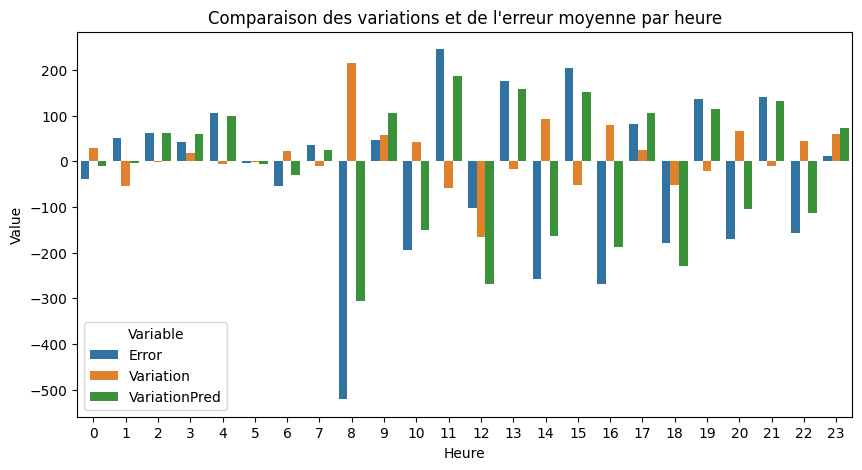

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Comparaison des variations et de l'erreur moyenne par heure")
tidy = X_test_mean[['heure', 'Error', 'Variation', 'VariationPred']].groupby('heure').mean().reset_index().melt(id_vars='heure').rename(columns=str.title)
sns.barplot(data=tidy, x='Heure', y='Value', hue='Variable')
plt.show()

And by season

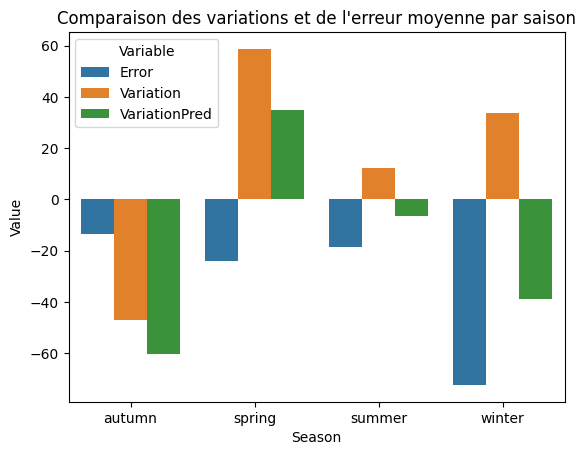

In [ ]:
tidy2 = X_test_mean[['season', 'Error', 'Variation', 'VariationPred']].groupby('season').mean().reset_index().melt(id_vars='season').rename(columns=str.title)
plt.title("Comparaison des variations et de l'erreur moyenne par saison")
sns.barplot(data=tidy2, x='Season', y='Value', hue='Variable')
plt.show()

We take the mean of variation by period

In [ ]:
X_test_mean.groupby(['isWeekday', 'isHoliday', 'season', 'heure'])[['Variation', 'VariationPred', 'Error']].mean().sort_values('VariationPred', ascending=False)

Variation  VariationPred        Error
isWeekday isHoliday season heure                                         
1         1         autumn 9       491.752381    1160.016016   668.263635
                    spring 15      275.045455    1114.281718   839.236263
                    winter 9       379.623693    1021.848788   642.225095
0         0         winter 13     -185.666667     796.910581   982.577248
                    autumn 18      357.784211     783.197824   425.413614
...                                       ...            ...          ...
1         1         autumn 8      -201.466667   -1023.542395  -822.075728
          0         winter 8      1417.733399   -1108.036859 -2525.770258
0         0         winter 18      381.027778   -1207.217273 -1588.245050
          1         spring 14    -2667.166667   -1360.001468  1307.165199
1         1         spring 8      -854.800000   -1610.807469  -756.007469

[365 rows x 3 columns]

Proportion de variation

In [ ]:
X_test_mean['Ratio'] = X_test_mean['Variation'] / X_test_mean['Frequentation'].replace(0, np.nan)
X_test_mean['Ratio'] = X_test_mean['Ratio'].abs()
X_test_mean['RatioPred'] = X_test_mean['VariationPred'] / X_test_mean['Frequentation'].replace(0, np.nan)
X_test_mean['RatioPred'] = X_test_mean['RatioPred'].abs()

In [ ]:
X_test_mean['Ratio'].describe()

,Ratio
count,3443.000000
mean,4.962137
std,131.496943
min,0.000029
25%,0.070489
50%,0.160350
75%,0.363823
max,7379.818182


In [ ]:
X_test_mean['RatioPred'].describe()

,RatioPred
count,3443.000000
mean,3.961621
std,72.838884
min,0.000010
25%,0.042711
50%,0.101319
75%,0.216258
max,3918.320701


## Modèle sans les données de météos

In [ ]:
from re import X
X_train_0 = X_train[['isWeekday', 'isHoliday', 'season_autumn', 'season_winter', 'season_spring', 'season_summer', 'heure']].copy()
X_test_0 = X_test[['isWeekday', 'isHoliday', 'season_autumn', 'season_winter', 'season_spring', 'season_summer', 'heure']].copy()
y_train_0 = y_train.copy()
y_test_0 = y_test.copy()

In [ ]:
model = HistGradientBoostingRegressor(random_state=520)
model.fit(X_train_0, y_train_0)

HistGradientBoostingRegressor(random_state=520)

In [ ]:
preds_0 = model.predict(X_test_0)

mae = mean_absolute_error(y_test_0, preds_0)
print(f"MAE : {mae}")
rmse = root_mean_squared_error(y_test_0, preds_0)
print(f"RMSE : {rmse}")
r2 = r2_score(y_test_0, preds_0)
print(f"R2 : {r2}")

MAE : 831.5983086825513
RMSE : 1309.091313341546
R2 : 0.9060193816979013


We see that we have better results with the meteo features